In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array

"""
    Created by Mohsen Naghipourfar on 7/25/18.
    Email : mn7697np@gmail.com or naghipourfar@ce.sharif.edu
    Website: http://ce.sharif.edu/~naghipourfar
    Github: https://github.com/naghipourfar
    Skype: mn7697np
"""

'\n    Created by Mohsen Naghipourfar on 7/25/18.\n    Email : mn7697np@gmail.com or naghipourfar@ce.sharif.edu\n    Website: http://ce.sharif.edu/~naghipourfar\n    Github: https://github.com/naghipourfar\n    Skype: mn7697np\n'

In [377]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)


# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq, n_features):

    # extract raw values
    raw_values = series.values
    supervised = series_to_supervised(raw_values, n_lag, n_seq)
    supervised_values = supervised.values
    

    # transform data to be stationary
    diff_series = difference(supervised_values, 1)
    diff_values = diff_series.values
    print(pd.DataFrame(diff_values))
#     diff_values = diff_values.reshape(len(diff_values), 1)

    # rescale values to -1, 1
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(supervised_values)
    print(pd.DataFrame(scaled_values))
    # print(scaled_values.shape)
    # scaled_values = scaled_values.reshape(len(scaled_values), 1)

    # transform into supervised learning problem X, y
    X, y = get_X_y(supervised_values, n_lag, n_seq, n_features, 5)
    y_scaler = y_scaler.fit(y)

    # split into train and test sets
    train, test = scaled_values[0:-n_test], scaled_values[-n_test:]
    return scaler, train, test, y_scaler

def get_X_y(data, n_lag, n_seq, n_features, y_col_idx):
    y_columns = [n_features * (n_lag) + y_col_idx + n_features * i for i in range(n_seq)]
    print(y_columns)
    y = data[:, y_columns]
    X = np.delete(data, y_columns, axis=1)
    X = X.reshape(X.shape[0], 1, X.shape[1])
    return X, y
    
    
    
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = get_X_y(train, n_lag, n_seq, n_features, 5)
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(0.5))
    model.add(Dense(y.shape[1], activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=2, shuffle=False, validation_split=0.3)
    # for i in range(nb_epoch):
    #     model.fit(X, y, epochs=1, batch_size=n_batch, verbose=2, shuffle=False)
    #     model.reset_states()
    return model


# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, -1)
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return [x for x in forecast[0, :]]


# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    X, y = get_X_y(test, n_lag, n_seq, n_features, 5)
    for i in range(len(test)):
#         X, y = test[i, 0:n_features*(n_lag)], test[i, n_features*(n_lag):]
        # make forecast
        forecast = forecast_lstm(model, X[i], n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts


# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i - 1])
    return inverted


# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        # forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform([forecast])
        inv_scale = inv_scale[0, :]
        # invert differencing
#         index = len(series) - n_test + i - 1
#         last_ob = series.values[index]
#         inv_diff = inverse_difference(last_ob, inv_scale)

        inverted.append(inv_scale)
    return inverted


# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i + 1), rmse))


# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test, n_lag, n_seq, training=False):
    pyplot.figure(figsize=(18, 10))
    pyplot.plot(series.values, label="real Data", color='blue')
    for i in range(len(forecasts)):
        if training:
            off_s = i
            off_e = off_s + len(forecasts[i])
        else:
            off_s = len(series) - n_test + i - 1
            off_e = off_s + len(forecasts[i])
        xaxis = [x for x in range(off_s, off_e)]
#         yaxis = [series.values[off_s]] + forecasts[i] # !!!
        yaxis = forecasts[i]
#         print(xaxis, yaxis)
        if i == 0:
            pyplot.plot(xaxis, yaxis, color='red', label='predicted')
        else:
            pyplot.plot(xaxis, yaxis, color='red')
    pyplot.legend()
    pyplot.show()

def plot_discrete_points(series, forecasts, step=100):
    pyplot.figure(figsize=(18, 10))
    pyplot.plot(series.values, label="real Data", color='blue')
    for i in range(0, len(forecasts), step):
#         if training:
        off_s = i
        off_e = off_s + len(forecasts[i])
#         else:
#             off_s = len(series) - n_test + i - 1
#             off_e = off_s + len(forecasts[i])
        xaxis = [x for x in range(off_s, off_e)]
#         yaxis = [series.values[off_s]] + forecasts[i] # !!!
        yaxis = forecasts[i]
#         print(xaxis, yaxis)
        if i == 0:
            pyplot.plot(xaxis, yaxis, color='red', label='predicted')
        else:
            pyplot.plot(xaxis, yaxis, color='red')
    pyplot.legend()
    pyplot.show()

In [347]:
# X, y = get_X_y(train, n_lag, n_seq, n_features, 5)
# X[0].shape
# forecast_lstm(model, X[0], n_batch)
len(forecasts)

1991

In [378]:
# load dataset
series = pd.read_csv('./data.csv', header=None)[[i for i in range(1, 7)]]

# configure
n_seq = 3
n_lag = 20
n_test = 10
n_epochs = 15
n_batch = 1
n_neurons = 150
n_features = 6

# prepare data
scaler, train, test, y_scaler = prepare_data(series, n_test, n_lag, n_seq, n_features)

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

         0       1       2         3             4       5       6       7    \
0       0.71   -0.30    0.79 -49309.22 -1.007619e+06    0.09    0.09   -0.63   
1       0.09   -0.63   -2.30  30584.17  5.327061e+05   -0.87   -0.87    0.40   
2      -0.87    0.40    1.42 -46257.35 -8.734757e+05    0.96    0.96    0.15   
3       0.96    0.15    0.44  17974.84  3.727206e+05   -0.16   -0.16   -0.26   
4      -0.16   -0.26    0.34 -23006.70 -4.656205e+05    0.17    0.17    0.54   
5       0.17    0.54    0.40  22777.16  4.954465e+05    0.58    0.58    0.89   
6       0.58    0.89    0.17  12274.17  2.920697e+05    0.97    0.97    0.55   
7       0.97    0.55    1.23 -15613.84 -2.977873e+05    0.51    0.51    1.22   
8       0.51    1.22    0.58 -10516.92 -2.046445e+05    0.99    0.99    0.12   
9       0.99    0.12    0.09  18293.06  4.354797e+05    0.32    0.32    0.57   
10      0.32    0.57    0.98 -26899.34 -6.090550e+05    0.68    0.68    1.15   
11      0.68    1.15    0.65  44713.20  

In [379]:
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, y_scaler, n_test + 2)
forecasts[4]
# pd.DataFrame(forecasts)

[125, 131, 137]


array([502.2470377 , 321.24156811, 391.99704908])

[125, 131, 137]
[125, 131, 137]
[125, 131, 137]
(1979, 3)


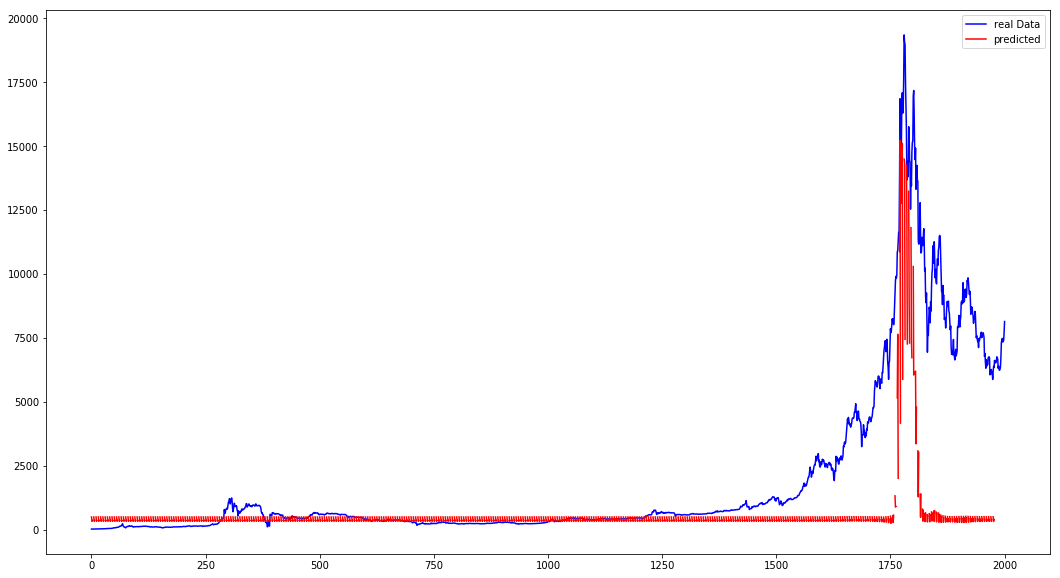

In [380]:
# make forecasts
test_forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# print(pd.DataFrame(forecasts))

# inverse transform forecasts and test
test_forecasts = inverse_transform(series, test_forecasts, y_scaler, n_test + 2)
# actual = [row[n_features*(n_lag):] for row in test]
X, y = get_X_y(test, n_lag, n_seq, n_features, 5)
# actual = inverse_transform(series, y, y_scaler, n_test + 2)

# evaluate forecasts
# evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# training forecasts
train_forecasts = make_forecasts(model, n_batch, train, train, n_lag, n_seq)
train_forecasts = inverse_transform(series, train_forecasts, y_scaler, n_test + 2)
forecasts = np.concatenate([train_forecasts, test_forecasts], axis=0)
print(pd.DataFrame(forecasts).shape)

# plot forecasts
plot_discrete_points(series[6], forecasts, step=5)

In [302]:
s = MinMaxScaler()
s = s.fit([[1, 2, 3, 4]])

In [366]:
scaler.

array([-0.99991721, -0.99997078, -0.99976512, -0.89926282, -0.99987484,
       -0.99989962, -0.99989962, -0.99991637, -0.99972241, -0.81961473,
       -0.99971619, -0.99983959, -0.9998396 , -0.9998267 , -0.99970426,
       -0.77669392, -0.99962266, -0.99973921, -0.99973922, -0.9998005 ,
       -0.99972453, -0.83129303, -0.99971802, -0.99976921, -0.99976922,
       -0.99967758, -0.99970957, -0.86806901, -0.99978355, -0.99966675,
       -0.99966677, -0.99966549, -0.99973626, -0.80410111, -0.9996441 ,
       -0.99965123, -0.99965125, -0.99966246, -0.99967432, -0.8981638 ,
       -0.99983913, -0.99964087, -0.99964089, -0.99963624, -0.99962307,
       -0.74180889, -0.99947084, -0.99968742, -0.99968744, -0.99964429,
       -0.99973624, -0.68617318, -0.99933177, -0.9998406 , -0.99984061,
       -0.99963621, -1.        , -0.49180297, -0.99887915, -0.99963047,
       -0.99963049, -0.99965737, -0.99953228, -0.82057794, -0.99962024,
       -0.99967601, -0.99967603, -0.99971581, -0.99945646, -0.93

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

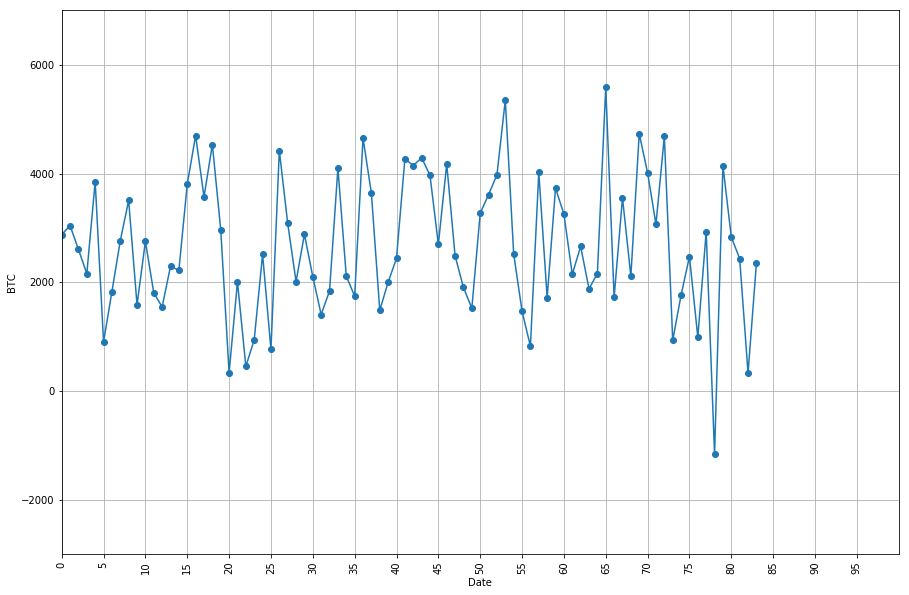

In [54]:
plt.figure(figsize=(15, 10))
plt.plot(pd.read_csv("./prediction.csv", header=None).transpose(), '-o')
plt.axis([0, 100, -3000, 7000])
plt.xticks([i for i in range(0, 100, 5)], rotation=90)
plt.xlabel("Date")
plt.ylabel("BTC")
plt.grid()
plt.show()